<a href="https://colab.research.google.com/github/sreevani-narayan/25-9-19/blob/master/twitter_health_tweets_(3)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns 


from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from sklearn.metrics import classification_report

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Corona_NLP_train.csv',encoding='latin1')

test = pd.read_csv('/content/drive/MyDrive/Corona_NLP_test (1).csv',encoding='latin1')

# Combine train and test set
df = train.append(test, ignore_index=True)

<ipython-input-3-9ac1140523ce>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test, ignore_index=True)


In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
df.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


<Axes: xlabel='Sentiment', ylabel='count'>

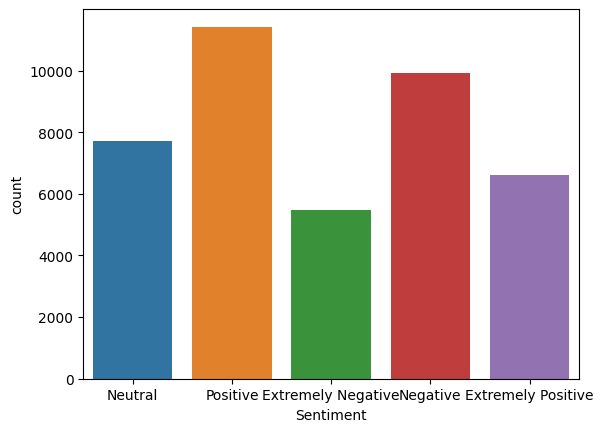

In [8]:
 sns.countplot(data=train, x='Sentiment')

<Axes: xlabel='Sentiment', ylabel='count'>

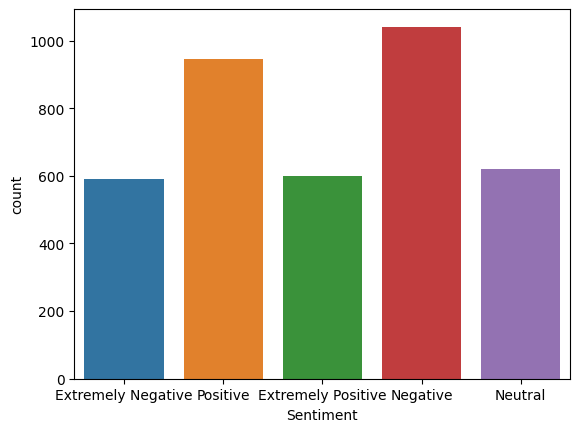

In [9]:
 sns.countplot(data=test, x='Sentiment')

<Axes: xlabel='Location'>

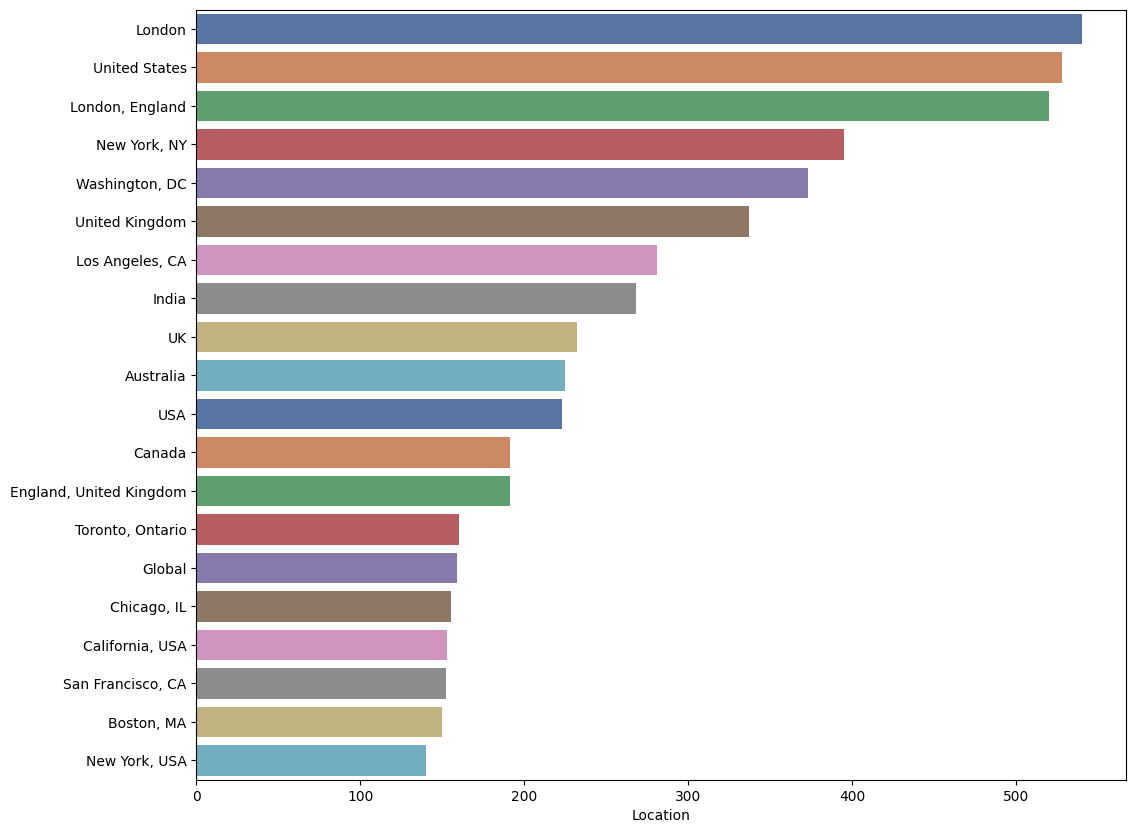

In [10]:
location = train["Location"].value_counts()[:20]
plt.subplots(figsize=(12,10))
sns.barplot(y=location.index, x=location, palette="deep", data=train)

In [11]:
import plotly.express as px
vals = [len(df[df['Sentiment']=='Negative']['Sentiment']), len(df[df['Sentiment']=='Positive']['Sentiment']), len(df[df['Sentiment']=='Neutral']['Sentiment'])]
idx = ['Negative', 'Positive', 'Neutral']
fig = px.pie(
    df,
    names='Sentiment',
    title='Target Value Distribution Chart',
    color_discrete_sequence=px.colors.sequential.Agsunset
)
fig.show()

In [12]:
# Convert sentiment into Positive/related to medical condition = 2 , Neutral/ Ambiguous = 1 , Negative / not related to medical condition =  0
def convert_Sentiment(sentiment):
    if sentiment == "Extremely Positive":
        return 2
    elif sentiment == "Extremely Negative":
        return 0
    elif sentiment == "Positive":
        return 2
    elif sentiment == "Negative":
        return 0
    else:
        return 1

In [13]:
# Apply convert_Sentiment function
df.Sentiment = df.Sentiment.apply(lambda x : convert_Sentiment(x))

2    19592
0    17031
1     8332
Name: Sentiment, dtype: int64
**********************************************************************


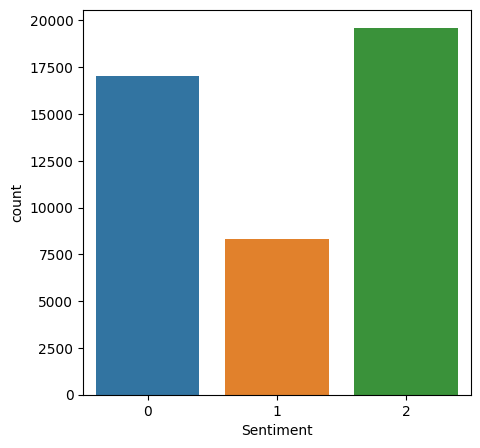

In [14]:
# Visualize Sentiment
print(df.Sentiment.value_counts())
print('*' * 70)
plt.figure(figsize = (5,5)) 
sns.countplot(x = 'Sentiment',data = df)
plt.show()

In [15]:
def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", s)
    return " ".join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

In [16]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_url(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_emoji(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : decontraction(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : char(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())

In [17]:
# Split sentiment groups 
Positive = df[df['Sentiment'] == 2].OriginalTweet
Neutral  = df[df['Sentiment'] == 1].OriginalTweet
Negative = df[df['Sentiment'] == 0].OriginalTweet

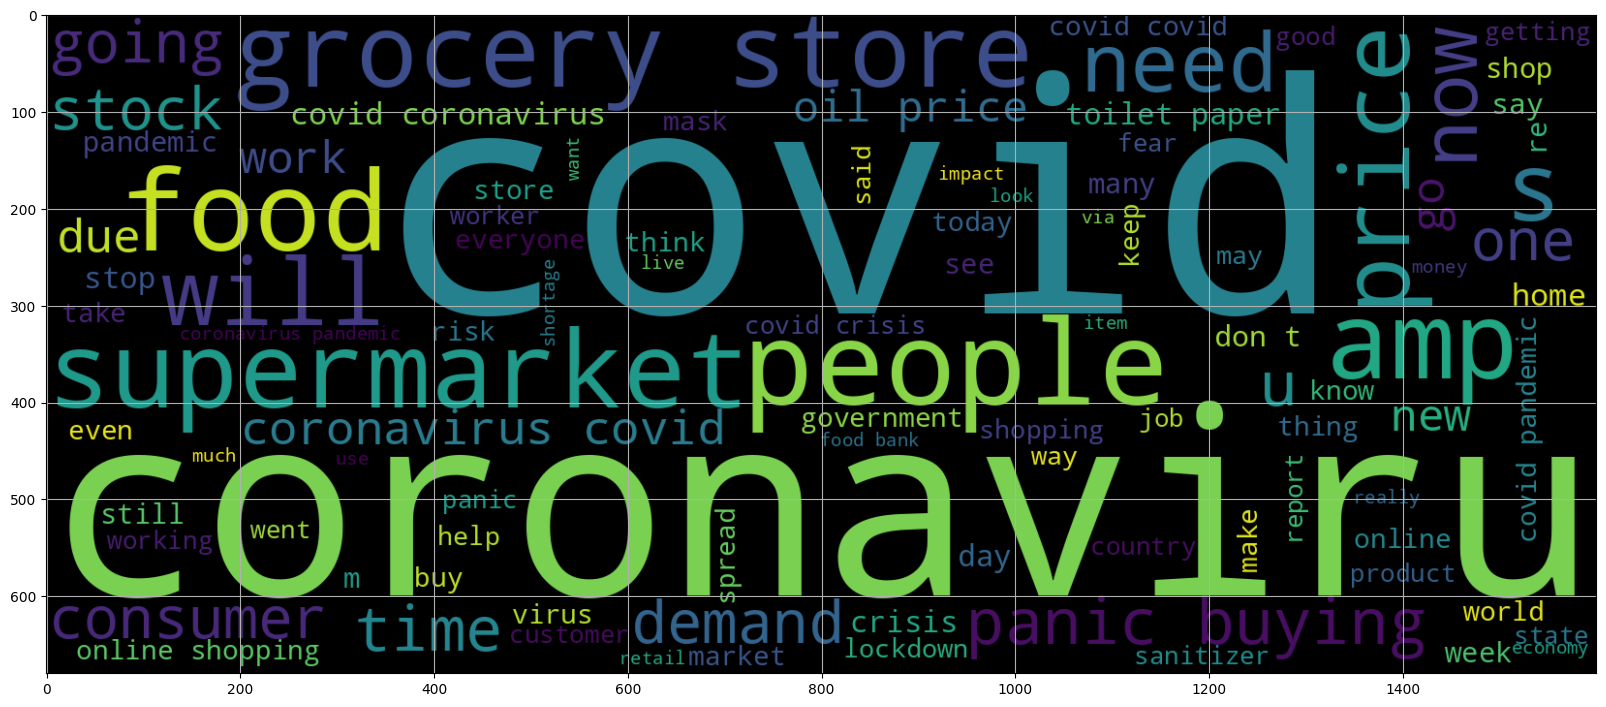

In [18]:
# Worldcould of  Negative Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 100 , width = 1600 , height = 680).generate(" ".join(Negative))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

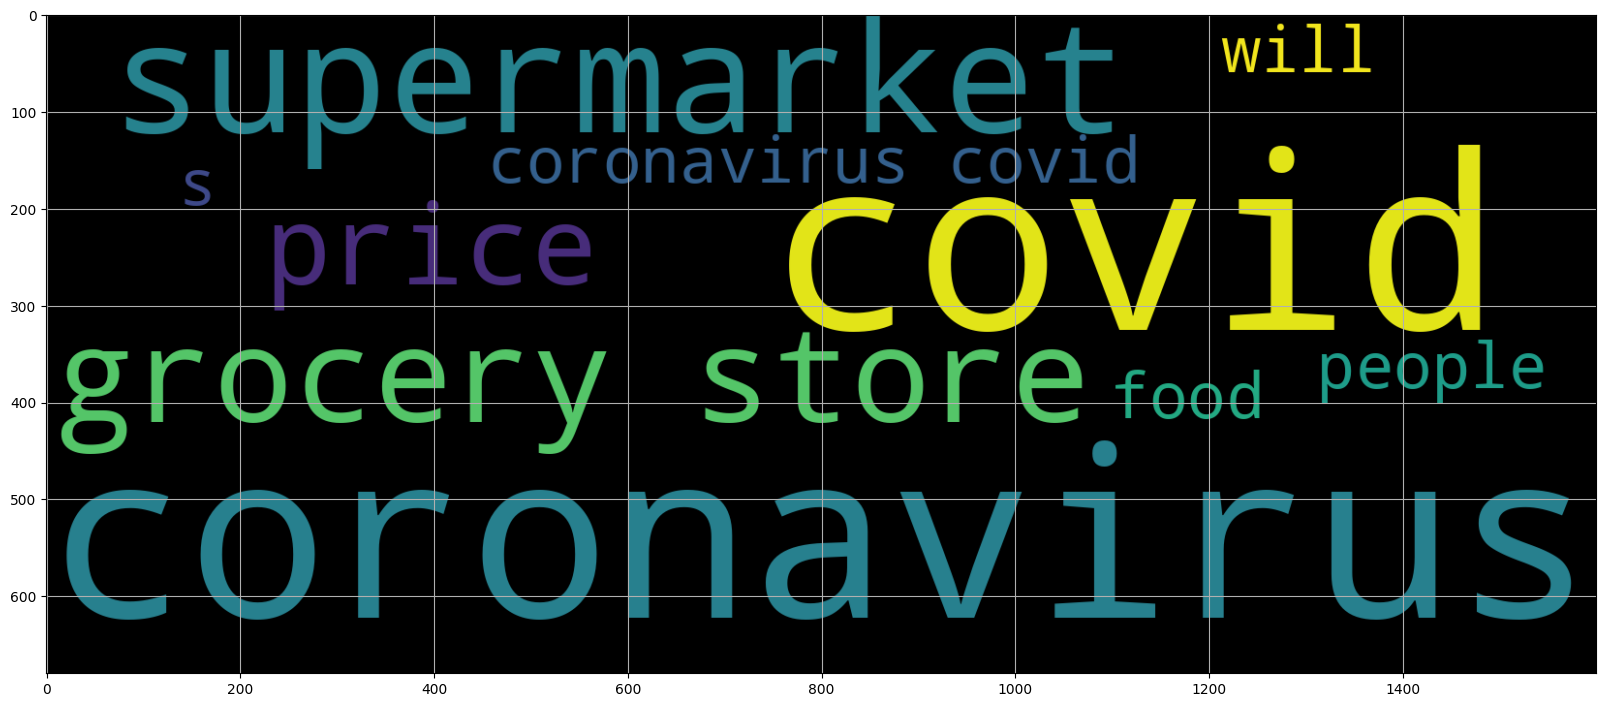

In [19]:
# Wordcould of Neutral Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words =10 , width = 1600 , height = 680).generate(" ".join(Neutral))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

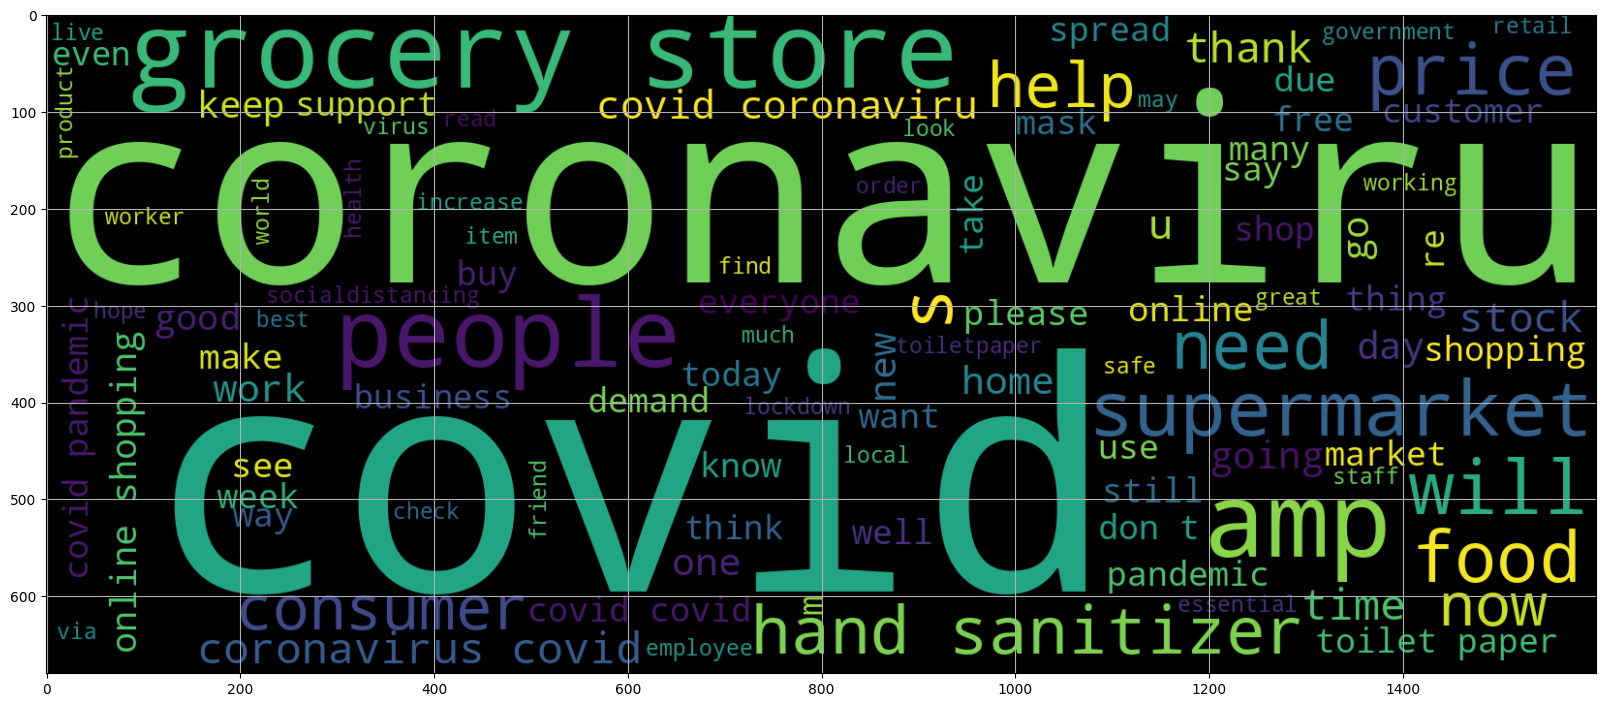

In [20]:
# Wordcould of Positive Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 100 , width = 1600 , height = 680).generate(" ".join(Positive))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

In [21]:
X = df['OriginalTweet']
y = df['Sentiment']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [22]:
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (35964,)
Shape of y_train :  (35964,)
Shape of X_test :  (8991,)
Shape of y_test :  (8991,)


In [23]:
# Convert y to categorical 
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)

In [24]:
# Tokenize Texts
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [25]:
# convert tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [26]:
# Create Model  
inp = Input(shape=(maxlen, )) 
x   =  Embedding(max_features, embed_size)(inp)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(3, activation="softmax")(x)

In [27]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
model.fit(X_train_final,y_train, epochs=2,validation_data=(X_test_final,y_test))

Epoch 1/2
1124/1124 [==============================] - 268s 235ms/step - loss: 0.5848 - accuracy: 0.7646 - val_loss: 0.3958 - val_accuracy: 0.8643
Epoch 2/2
1124/1124 [==============================] - 264s 235ms/step - loss: 0.2999 - accuracy: 0.8990 - val_loss: 0.3668 - val_accuracy: 0.8699


In [29]:
# Evaluate
model.evaluate(X_test_final,y_test)

281/281 [==============================] - 12s 43ms/step - loss: 0.3668 - accuracy: 0.8699


[0.3668462932109833, 0.8698698878288269]

In [30]:
# Predict test
lstm_pred = np.round(model.predict(X_test_final))

281/281 [==============================] - 13s 44ms/step


In [31]:
# Precision , Recall , F1-score
cr = classification_report(y_test,lstm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      3466
           1       0.92      0.78      0.84      1683
           2       0.86      0.92      0.89      3842

   micro avg       0.88      0.86      0.87      8991
   macro avg       0.89      0.84      0.86      8991
weighted avg       0.89      0.86      0.87      8991
 samples avg       0.86      0.86      0.86      8991



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.tokenize import casual_tokenize


In [ ]:
tweets_raw = df['OriginalTweet']
tweets = tweets_raw.apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str(x)))
tweets.head(5)

0                 menyrbie phil gahan chrisitv and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: OriginalTweet, dtype: object

In [ ]:
vectorizer = TfidfVectorizer(lowercase=True,
                            tokenizer = casual_tokenize,
                            min_df = 0.0004,
                            max_df=0.65)
representation = vectorizer.fit_transform(tweets).toarray()

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(representation,
                                                 df['Sentiment'])

In [ ]:
logreg_model_check = LogisticRegression(penalty='elasticnet',solver="saga",l1_ratio=0.9,n_jobs=-1).fit(x_train,y_train)


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(logreg_model_check.predict(x_test),y_test))

0.8394874988878014
